In [1]:
import pandas as pd 
import numpy as np 
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import linear_regression
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler

OUTDATED_IGNORE=1

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Part Biii: Mahalanobis Distance 

This noteook consists of the steps required to run the PartB analysis. Overall goal is to compute individual per bundle distance of the preterm population to the population of controls.<br><br>

Firstly, the preterms are again split into the extreme and moderate groups as we have shown previously that these two compare differently to the control group. The **3 populations are then corrected separately**:<br>

bundle metric ~ (scang age + birth age + residual WM) + mean(metric) <br>
with the residual WM being the remainder of the fit agains age at scan and age at birth<br><br>

Steps:
1. Scale all metric columns together (bundle + WM) to be in range <0,1>
2. Separate 3 groups: extreme, moderate, controls 
3. Correct separately as described above 
4. Compute distance to control 

Afterwards, plot the mahalanobis per bundle as box plots. <br>
Perform paired t-tests between the bundles. 

In [2]:
### some functions
 
def get_clinical_variables(iFile='../../DerivedData/Global.csv'):
    clinic = pd.read_csv(iFile, sep=';')
    
    #to_keep = ['ParticipantID', 'FetalGrowthRestriction', 'ParenteralNutrition>21d', 'Pregnancy-size', 
    #      'Sex', 'Gabirth', 'PMA-MRI']
    #to_keep = ['ParticipantID', 'FetalGrowthRestriction', 'Gabirth', 'PMA-MRI']
    to_keep = ['ParticipantID', 'Gabirth', 'PMA-MRI']
    
    clinic = clinic[to_keep]
    clinic.rename( columns ={
                'ParticipantID' : 'subject_id',
                'ParenteralNutrition>21d' : 'ParenteralNutrition',
                'Pregnancy-size' : 'PregnancySize', 
                'Gabirth' : 'birth_age',
                'PMA-MRI' : 'scan_age'
                }, inplace=True)
    
    ## correct excel commas in floats
    for col in ['birth_age', 'scan_age']:
        clinic[col] = clinic[col].astype(str)
        clinic[col] = clinic[col].apply(lambda x: x.replace(',','.'))
        clinic[col] = clinic[col].astype(np.float16)
        
    ### categorize what needs to be categorized

    #for col in ['ParenteralNutrition','PregnancySize', 'FetalGrowthRestriction', 'Sex']:
    #for col in [ 'FetalGrowthRestriction']:
    #    clinic[col] = clinic[col].astype('category')
    #    clinic[col] = clinic[col].cat.codes
   
    return clinic

def _get_meanWM(group):
    

    ex_WM = pd.read_csv('../../DerivedData/extreme_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)
    mod_WM = pd.read_csv('../../DerivedData/moderate_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)

    WM = pd.concat([ex_WM, mod_WM])
    WM.rename(columns={'matched_ID' : 'control_ID'}, inplace=True)
        
    cols = [col for col in WM.columns if group in col]
    cols = [col for col in cols if 'post' not in col]
        
    WM = WM[cols]
    WM = WM.set_axis(['meanWM_'+col.split('_')[1] for col in cols] , axis=1, inplace=False)
    WM.reset_index(drop=True, inplace=True)
    WM.rename(columns={'meanWM_ID': 'subject_id'}, inplace =True)
    
    return WM 
        
def import_WM():
    
    preterm_WM = _get_meanWM('preterm')
    control_WM = _get_meanWM('control')

    WM = pd.concat([preterm_WM, control_WM])
    return WM


def _min_max_scale(X, range):
    mi, ma = range
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (ma - mi) + mi
    return X_scaled

def scale_over_metrics(df, metrics, range=(0,1)):
    
    df = df.copy()
    
    for metric in metrics:
        features = [col for col in df.columns if metric in col]
        df[features] = _min_max_scale(df[features].values, range=range)
    

    return df
    

In [3]:
### the bundles of interest, fix the ordering for plots 
## to fix the ordering for plots 
pair_names = [
    'M1-Brainstem', 'S1-Brainstem','Paracentral-Brainstem',
    'M1-Caud', 'S1-Caud','Paracentral-Caud',
    'M1-Lenti', 'S1-Lenti','Paracentral-Lenti', 
    'M1-Thalfus', 'S1-Thalfus','Paracentral-Thalfus', 
    'M1L-M1R', 'S1L-S1R',
    'S1-M1' ]

metrics = ['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']

#sets = [['AD','RD', 'FA', 'MD'], ['NDI', 'ODI']]
#set_names = ['set1', 'set2']

sets = [['AD','RD'], ['FA', 'MD'], ['NDI', 'ODI']]
set_names = ['set1', 'set2', 'set3']

### 1. Read in and pre-process the data

In [4]:
## first deal with the control population (take only the matches!)
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

# the airing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#get matched controls
controls = controls[controls.subject_id.isin(matched.matched_ID_with_outcome.values)]
df = pd.concat([preterms, controls])

### GET MEAN WM 
df = pd.merge(df,  import_WM(), how='inner', on=['subject_id'])

### SCALE OVER metrics 
df = scale_over_metrics(df, metrics=metrics, range=(0,1))

### get clinical variables 
df = pd.merge(df,  get_clinical_variables(), how='inner', on=['subject_id']) 


### 2. Separate 3 groups: extreme, moderate & control 

In [5]:
### get matching + extreme/moderate grouping 
extreme_and_match = pd.read_csv('../../DerivedData/extreme_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)[['preterm_ID', 'matched_ID']]
moderate_and_match = pd.read_csv('../../DerivedData/moderate_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)[['preterm_ID', 'matched_ID']]
  
extreme_ids = extreme_and_match.preterm_ID.values
moderate_ids = moderate_and_match.preterm_ID.values
control_ids = np.concatenate([extreme_and_match.matched_ID.values , moderate_and_match.matched_ID.values])

## sanity check 
if len(extreme_ids) + len(moderate_ids) + len(control_ids) == len(df):
    print('all good')
else: 
    print('Problem with separation')
    
extreme = df[df.subject_id.isin(extreme_ids)].copy()
moderate = df[df.subject_id.isin(moderate_ids)].copy()
control = df[df.subject_id.isin(control_ids)].copy()

all good


In [45]:
clinic = pd.read_csv('../../DerivedData/Global.csv', sep=';')
to_keep = ['ParticipantID', 'Sex']
clinic = clinic[to_keep]
clinic.rename( columns ={
                'ParticipantID' : 'subject_id',
                }, inplace=True)
        

In [46]:
extreme = pd.merge(extreme,  clinic, how='inner', on=['subject_id']) 

In [48]:
len(extreme[extreme['Sex'] == 'Male'])

18

## 3. Correct the metric values 

In [6]:
def correct_metrics(df, metrics, bundles):
    
    df= df.copy()
    temp = df.copy()
    
    for metric in metrics:
        temp['residual_WM_' + metric] = _get_WM_residuals(df=temp, metric=metric)
        
        for bundle in bundles:
            
            df[bundle + '_' + metric] = _get_metric_residuals(df=temp, bundle=bundle, metric=metric)
    
    return df
    
        

def _get_WM_residuals(df, metric):
    from pingouin import linear_regression
    df = df.copy()
    
    df['scan_age'] = np.float32(df['scan_age'].values)
    df['birth_age'] = np.float32(df['birth_age'].values)
    df['meanWM_' + metric] = np.float32(df['meanWM_' + metric].values)
    
    lm = linear_regression( X= df[['scan_age', 'birth_age']], y = df['meanWM_' + metric])
    #lm = linear_regression( X= df['scan_age'], y = df['meanWM_' + metric])
    return lm.residuals_
    
def _get_metric_residuals(df, bundle, metric):
    
    from pingouin import linear_regression
    df = df.copy()
    
    df[bundle+'_'+ metric] = np.float32(df[bundle+'_'+ metric].values)
    df['scan_age'] = np.float32(df['scan_age'].values)
    df['birth_age'] = np.float32(df['birth_age'].values)
    df['residual_WM_' + metric] = np.float32(df['residual_WM_' + metric].values)
    
    correction = ['scan_age', 'birth_age', 'residual_WM_' + metric]
    
    mean = np.mean(df[bundle+'_'+metric].values)
    
    lm = linear_regression( X= df[correction], y = df[bundle+'_'+ metric])
    
    return lm.residuals_ + mean
    
    
    

In [7]:
extreme_cor = correct_metrics(df=extreme, metrics=metrics, bundles=pair_names)
moderate_cor = correct_metrics(df=moderate, metrics=metrics, bundles=pair_names)
control_cor = correct_metrics(df=control, metrics=metrics, bundles=pair_names)

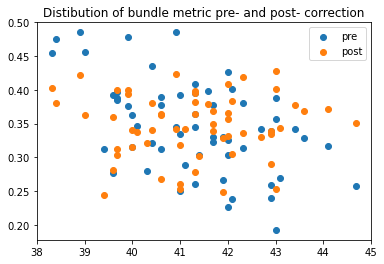

In [8]:
## sanity check 
plt.title('Distibution of bundle metric pre- and post- correction')
plt.scatter(control['scan_age'], control['S1-Brainstem_AD'], label='pre')
plt.scatter(control_cor['scan_age'], control_cor['S1-Brainstem_AD'], label='post')
plt.legend()
plt.show()

### 4. Compute mahalanobis distance

In [9]:
def get_mahalanobis_bundles(effect_group, control_group, bundles, sets, set_names):
    mah_results = pd.DataFrame()
    
    for bundle in bundles:
        for subset, name in zip(sets, set_names):
            features = np.array([bundle+'_'+metric for metric in subset])
           
            control_ar = control_group[features]
            ### normalize by mean 
            mean_control = np.mean(control_ar, axis=0)
            control_ar = (control_ar / mean_control)
            
            ## get inverse covariance matrix for the control group 
            corr = np.cov(control_ar.T)
            corrI = np.linalg.inv(corr)
            
            distances = []
            for i, preterm in enumerate(effect_group.subject_id.values):
                subj_vect = effect_group[effect_group.subject_id == preterm][features].values[0]
                subj_vect = (subj_vect / mean_control)# / range_control
                cont_vect = np.mean(control_ar, axis=0) 
                
                mh = mahalanobis(u = subj_vect, v = cont_vect, VI=corrI)
                
                mah_results.loc[i,'subject_id'] = preterm
                mah_results.loc[i, bundle+'_mh_'+name] = mh
            
    return mah_results
    

In [10]:
extreme_mh_results = get_mahalanobis_bundles(effect_group=extreme_cor, control_group=control_cor, bundles=pair_names, sets=sets, set_names=set_names)
moderate_mh_results = get_mahalanobis_bundles(effect_group=moderate_cor, control_group=control_cor, bundles=pair_names, sets=sets, set_names=set_names)


In [9]:
#extreme_mh_results.to_csv('../../Results/mahalanabis_bundle_metrics_extreme_pt.csv')
#moderate_mh_results.to_csv('../../Results/mahalanabis_bundle_metrics_moderate_pt.csv')

extreme_mh_results = pd.read_csv('../../Results/mahalanabis_bundle_metrics_extreme_pt.csv', index_col=0)
moderate_mh_results = pd.read_csv('../../Results/mahalanabis_bundle_metrics_moderate_pt.csv', index_col=0)


In [10]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color='darkgray')
    plt.setp(bp['caps'], color='darkgray')
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color='darkgray', alpha=0.5)

In [14]:
old_tract_ordering = [
    
    'M1-Brainstem_mh_',
    'S1-Brainstem_mh_',
    'Paracentral-Brainstem_mh_',
    
    'M1-Caud_mh_',
    'S1-Caud_mh_',
    'Paracentral-Caud_mh_',
    
    'M1-Lenti_mh_',
    'S1-Lenti_mh_',
    'Paracentral-Lenti_mh_',
    
    'M1-Thalfus_mh_',
    'S1-Thalfus_mh_',
    'Paracentral-Thalfus_mh_',
    
    'M1L-M1R_mh_',
    'S1L-S1R_mh_',
    'S1-M1_mh_',
    ]

#M1 == preC, S1 == postC, Paracentral == paraC
old_tract_ord_names = [ 'PreC-Brainstem', 'PostC-Brainstem','ParaC-Brainstem',
                    'PreC-Caud','PostC-Caud','ParaC-Caud',
                    'PreC-Lenti','PostC-Lenti','ParaC-Lenti',
                    'PreC-Thal','PostC-Thal','ParaC-Thal',
                    'PreC$_L$-PreC$_R$','PostC$_L$-PostC$_R$', 'PreC-PostC']


tract_ordering = [
    'S1-Brainstem_mh_',
    'M1-Brainstem_mh_',
    'Paracentral-Brainstem_mh_',
    
    'S1-Thalfus_mh_',
    'M1-Thalfus_mh_',
    'Paracentral-Thalfus_mh_',
    
    'S1-Caud_mh_',
    'M1-Caud_mh_',
    'Paracentral-Caud_mh_',
    
    'S1-Lenti_mh_',
    'M1-Lenti_mh_',
    'Paracentral-Lenti_mh_',
    
    'S1L-S1R_mh_',
    'M1L-M1R_mh_',
    'S1-M1_mh_',
    ]

#M1 == preC, S1 == postC, Paracentral == paraC
tract_ord_names = [
     'S1-Bstem','M1-Bstem','ParaC-Bstem',
    'S1-Thal','M1-Thal','ParaC-Thal',
     'S1-Caud','M1-Caud','ParaC-Caud',
     'S1-Lenti','M1-Lenti','ParaC-Lenti', 
    'S1$_L$-S1$_R$','M1$_L$-M1$_R$',
    'S1-M1' ]


In [15]:
unpaired = pd.read_csv('../../Results/Mahalanobis_bundle_specific_extreme_vs_moderate_ttest.csv')

In [16]:
def get_notation(sig_results,features):
    
    
    notation = []
    for name in features:
    
        row = name.split('_')[0]
        col = name.split('_')[-1]
        sig = sig_results[sig_results.tract == row][col].values[0]
        
        if sig <= 0.0001:
            notation.append('****')
            
        elif 0.0001 < sig <= 0.001:
            notation.append('***')
            
        elif 0.001 < sig <= 0.01:
            notation.append('**')
            
        elif 0.01 < sig <= 0.05:
            notation.append('*')  
        
        elif 0.05 < sig <= 0.1:
            notation.append('.') 
        else:
            notation.append(' ')
    return np.array(notation) 

In [17]:
get_notation(unpaired, features)

NameError: name 'features' is not defined

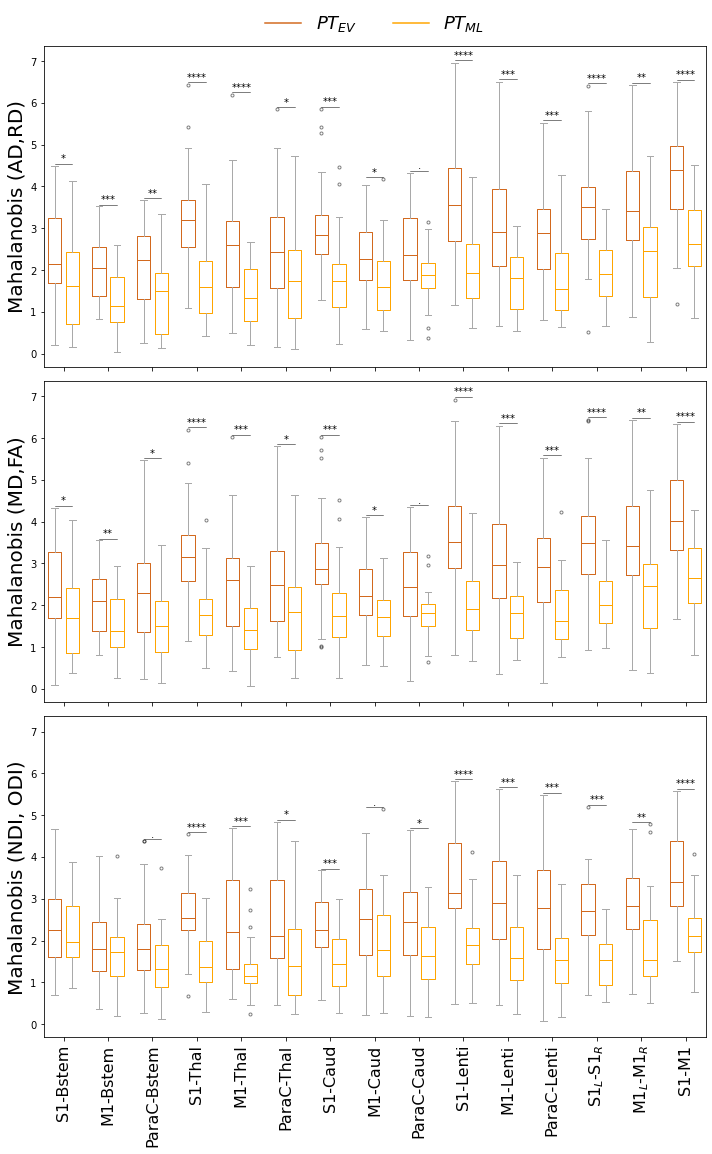

In [18]:
fig, axs = plt.subplots(3,1,  figsize=(10,16),sharey=True, sharex=True)

f = np.asarray([col for col in extreme_mh_results.columns if 'set1' in col])
means = np.mean(extreme_mh_results[f].values, axis=0)
srt = means.argsort()
f_sorted = f[np.argsort(means)][::-1]
f_sorted = [ f.split('set1')[0] for f in f_sorted]

extreme_df = extreme_mh_results.copy()
moderate_df = moderate_mh_results.copy()

#for i, subset in enumerate(set_names):
for i, subset in enumerate(['set1', 'set2', 'set3']):
    
    #features = [f + subset for f in f_sorted]
    features = [f + subset for f in tract_ordering]
    
    for col in features:
        
        upper_ex = np.mean(extreme_mh_results[col]) + (np.std(extreme_mh_results[col]) * 3)
        lower_ex = np.mean(extreme_mh_results[col]) - (np.std(extreme_mh_results[col]) * 3)
        
        upper_mod = np.mean(moderate_mh_results[col]) + (np.std(moderate_mh_results[col]) * 3)
        lower_mod = np.mean(moderate_mh_results[col]) - (np.std(moderate_mh_results[col]) * 3)
   
        extreme_df.loc[extreme_df[col] > upper_ex, col] = np.nan
        extreme_df.loc[extreme_df[col] < lower_ex, col] = np.nan
        
        moderate_df.loc[moderate_df[col] > upper_mod, col] = np.nan
        moderate_df.loc[moderate_df[col] < lower_mod, col] = np.nan
    
    
    #bpl = axs[i].boxplot(extreme_mh_results[features].values, positions=np.array(range(len(features)))*2.0-0.4, sym='.', 
    #        widths=0.6, vert=True, labels=features, showfliers=True)
    
    data_ex_mask =  ~np.isnan(extreme_df[features].values)
    filtered_data_ex = [d[m] for d, m in zip(extreme_df[features].values.T, data_ex_mask.T)]
    
    bpl = axs[i].boxplot(filtered_data_ex, positions=np.array(range(len(features)))*2.0-0.4, sym='.', 
            widths=0.6, vert=True, labels=features, showfliers=True)
    
    set_box_color(bpl, 'chocolate') ## extreme 
    
    #bpr = axs[i].boxplot(moderate_mh_results[features].values, positions=np.array(range(len(features)))*2.0+0.4, sym='.', 
    #        widths=0.6, vert=True, labels=features, showfliers=True)
    
    data_mod_mask =  ~np.isnan(moderate_df[features].values)
    filtered_data_mod = [d[m] for d, m in zip(moderate_df[features].values.T, data_mod_mask.T)]
    
    bpr = axs[i].boxplot(filtered_data_mod, positions=np.array(range(len(features)))*2.0+0.4, sym='.', 
            widths=0.6, vert=True, labels=features, showfliers=True)
    
    set_box_color(bpr, 'orange') ## moderate 
    
    if subset == 'set1':
        set_name = '(AD,RD)'
    elif subset == 'set2':
        set_name = '(MD,FA)'
    else:
        set_name = '(NDI, ODI)'
    
    axs[i].set_ylabel('Mahalanobis {}'.format(set_name), fontsize=20)


    ### plot significance 
    notation = get_notation(unpaired, features)
    for j, txt in enumerate(notation):
        if txt != ' ':
            x1,x2 = (np.array(range(len(features)))*2.0-0.4)[j], (np.array(range(len(features)))*2.0+0.4)[j]
            
            if extreme_df[features[j]].max() > moderate_df[features[j]].max():
                y, h, col = extreme_df[features[j]].max() * 1.01 , 0.00001, 'k'
            else: 
                y, h, col = moderate_df[features[j]].max() * 1.01, 0.00001, 'k'
                
            axs[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
            axs[i].text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=col)
            
            
#names = [col.split('_')[0] for col in features]    
names = tract_ord_names
ticks = np.array(range(len(features)))*2.0
   
plt.xticks(ticks, rotation=90, labels=names, fontsize=16)    

axs[0].plot([], c='chocolate', label='$PT_{EV}$')
axs[0].plot([], c='orange', label='$PT_{ML}$')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), 
           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   
    
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig('../../Results/figures/Mahalanobis_distribution_subgroups_3sets_with_significances.png', dpi=500)
plt.show()

In [19]:
print('Extreme outliers: {}'.format(extreme_df.isna().sum().sum()))
print('Moderate outliers: {}'.format(moderate_df.isna().sum().sum()))

Extreme outliers: 6
Moderate outliers: 3


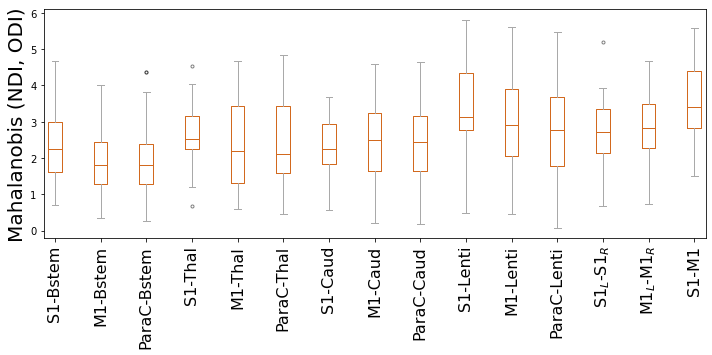

In [31]:
fig, axs = plt.subplots(1,1,  figsize=(10,5),sharey=True, sharex=True)

f = np.asarray([col for col in extreme_mh_results.columns if 'set1' in col])
means = np.mean(extreme_mh_results[f].values, axis=0)
srt = means.argsort()
f_sorted = f[np.argsort(means)][::-1]
f_sorted = [ f.split('set1')[0] for f in f_sorted]

extreme_df = extreme_mh_results.copy()
moderate_df = moderate_mh_results.copy()

#for i, subset in enumerate(set_names):
#for i, subset in enumerate(['set1', 'set2', 'set3']):
for i, subset in enumerate(['set3']):
    
    #features = [f + subset for f in f_sorted]
    features = [f + subset for f in tract_ordering]
    
    for col in features:
        
        upper_ex = np.mean(extreme_mh_results[col]) + (np.std(extreme_mh_results[col]) * 3)
        lower_ex = np.mean(extreme_mh_results[col]) - (np.std(extreme_mh_results[col]) * 3)
        
        extreme_df.loc[extreme_df[col] > upper_ex, col] = np.nan
        extreme_df.loc[extreme_df[col] < lower_ex, col] = np.nan
        

    
    data_ex_mask =  ~np.isnan(extreme_df[features].values)
    filtered_data_ex = [d[m] for d, m in zip(extreme_df[features].values.T, data_ex_mask.T)]
    
    bpl = axs.boxplot(filtered_data_ex, positions=np.array(range(len(features)))*2., sym='.', 
            widths=0.6, vert=True, labels=features, showfliers=True)
    
    set_box_color(bpl, 'chocolate') ## extreme 

    
    if subset == 'set1':
        set_name = '(AD,RD)'
    elif subset == 'set2':
        set_name = '(MD,FA)'
    else:
        set_name = '(NDI, ODI)'
    
    axs.set_ylabel('Mahalanobis {}'.format(set_name), fontsize=20)


    ### plot significance 
    #notation = get_notation(unpaired, features)
    #for j, txt in enumerate(notation):
        #if txt != ' ':
            #x1,x2 = (np.array(range(len(features)))*2.0-0.4)[j], (np.array(range(len(features)))*2.0+0.4)[j]
            
            
            #y, h, col = extreme_df[features[j]].max() * 1.01 , 0.00001, 'k'
            #axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
            #axs.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=col)
            
            
#names = [col.split('_')[0] for col in features]    
names = tract_ord_names
ticks = np.array(range(len(features)))*2.0
   
plt.xticks(ticks, rotation=90, labels=names, fontsize=16)    

axs.plot([], c='chocolate', label='$PT$')
#axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), 
#           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   
    
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig('../../Results/figures/Mahalanobis_distribution_PT_set3.png', dpi=500)
plt.show()

## 5. Bundle distances 


In [14]:
from itertools import combinations

ordering = pd.DataFrame(columns=['region1', 'region2', 'corrected_p_set1', 
                               'corrected_p_set2','corrected_p_set3'])

## moderate group 
subset='set1'

for subset in ['set1', 'set2', 'set3']:
    pvals = []
    for combination in list(combinations(pair_names, 2)):
        test = pg.ttest(extreme_mh_results[combination[0]+'_mh_'+subset].values,
                    extreme_mh_results[combination[1]+'_mh_'+subset].values, paired=True)
    
        p = "{:.9f}".format(test['p-val'].values[0])
        pvals.append(p)
    
    
    reject, pvals_corr = pg.multicomp(np.array(pvals).astype(np.float64), method='fdr_bh')
    
    i=0
    for val, combination in zip(pvals_corr, list(combinations(pair_names, 2))):
        #print(combination,  "{:.5f}".format(val))
        ordering.loc[i, 'region1'] = combination[0]
        ordering.loc[i, 'region2'] = combination[1]
        ordering.loc[i, 'corrected_p_'+subset] = "{:.5f}".format(val)
        i = i+1
    
    ordering['corrected_p_'+subset] = ordering['corrected_p_'+subset].astype(np.float64)

In [15]:
for i, row in ordering.iterrows():
    ordering.loc[i, 'region1_set1_mean'] = np.mean(moderate_mh_results[ row.region1 +'_mh_set1'])
    ordering.loc[i, 'region2_set1_mean'] = np.mean(moderate_mh_results[ row.region2 +'_mh_set1'])
    
    
    ordering.loc[i, 'region1_set2_mean'] = np.mean(moderate_mh_results[ row.region1 +'_mh_set2'])
    ordering.loc[i, 'region2_set2_mean'] = np.mean(moderate_mh_results[ row.region2 +'_mh_set2'])
    
    
    ordering.loc[i, 'region1_set3_mean'] = np.mean(moderate_mh_results[ row.region1 +'_mh_set3'])
    ordering.loc[i, 'region2_set3_mean'] = np.mean(moderate_mh_results[ row.region2 +'_mh_set3'])

In [16]:
#ordering.to_csv('../../Results/new_mahalanobis_extreme_group_ordering.csv')

In [17]:
#ordering[ordering.corrected_p_set1 > 0.05].sort_values(by='region1_set1_mean')
#ordering

In [18]:
#a = pd.read_csv('../../Results/mahalanobis_moderate_group_ordering.csv')

In [10]:
ordering = pd.read_csv('../../Results/new_mahalanobis_extreme_group_ordering.csv')

In [18]:
regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
edges = []
weights = []

for i, row in ordering.iterrows():
    if row.corrected_p_set1 > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p_set1)

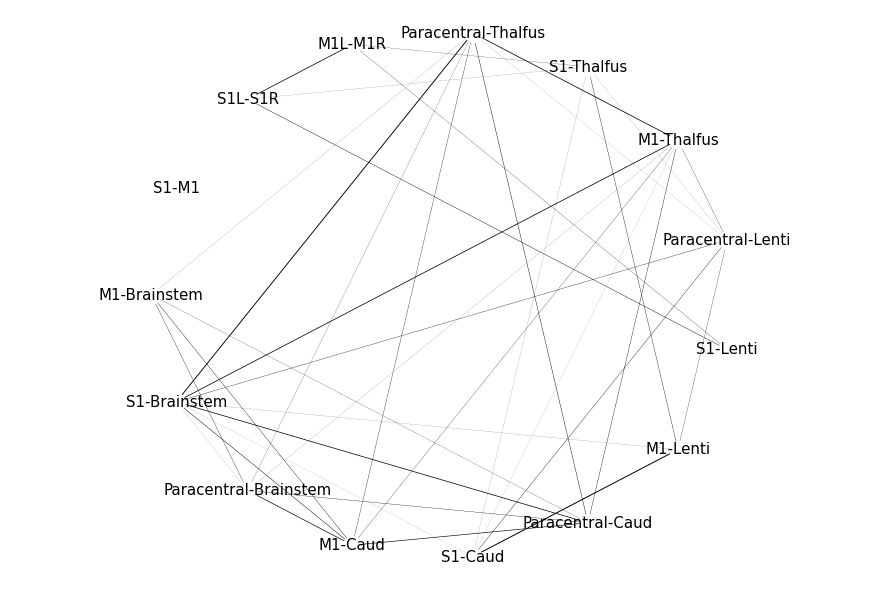

In [19]:
import networkx as nx 
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)

options = {
    'font_size': 15,
    #'node_size' : 5000,
    'node_color': 'white',
    #'edgecolors' : 'black',
    'linewidths': 1.5,
    'width': list(weights)
}

plt.figure(figsize=(12,8))

pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels= True, **options)

x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

## 6. Correlation with mahalanobis distance with outcome

In [13]:
# get oucomes 


def get_outcomes(iFile='../../DerivedData/Global.csv' ):
    clinic = pd.read_csv(iFile, sep=';')
    to_keep = ['ParticipantID', 'Cognitive-CompositeScore', 'Communication-CompositeScore', 'Motor-CompositeScore','Cognitive-ScaledScore',
                 'ReceptiveCom-ScaledScore', 'ExpressiveCom-ScaledScore', 'FineMotor-ScaledScore','GrossMotor-ScaledScore']
    clinic= clinic[to_keep]

    clinic.rename( columns ={
                'ParticipantID' : 'subject_id',
                'Cognitive-CompositeScore' : 'Cognitive',
                'Communication-CompositeScore' : 'Language', 
                'Motor-CompositeScore' : 'Motor',
                }, inplace=True)
    
    return clinic


#extreme_mh_results

In [14]:
### get clinical variables 
extreme_mh_outcomes = pd.merge(extreme_mh_results,  get_outcomes(), how='inner', on=['subject_id']) 
extreme_mh_outcomes.dropna(inplace=True)

moderate_mh_outcomes = pd.merge(moderate_mh_results,  get_outcomes(), how='inner', on=['subject_id']) 
moderate_mh_outcomes.dropna(inplace=True)

## plotting the significant for reviewer 2 
Cognitive Scaled & Fine Motor Scaled only specific bundles => extreme group

In [18]:
#out_rew = ['Cognitive-ScaledScore', 'ReceptiveCom-ScaledScore', 'ExpressiveCom-ScaledScore',
#           'FineMotor-ScaledScore','GrossMotor-ScaledScore']

out_rew = ['Cognitive-ScaledScore', 'FineMotor-ScaledScore']

#ttl = ['Cog', 'RecCom', 'ExpCom', 'FineMot', 'GrossMot']
ttl = ['Cog',  'FineMot']

c_scheme_rew = {
    'M1-Brainstem_mh_set3': ['orangered', '^', 'M1-Bstem'], 
    'Paracentral-Brainstem_mh_set3': ['orange','o', 'ParaC-Bstem'],
    'M1-Lenti_mh_set3': ['limegreen', '^', 'M1-Lenti'],
    'Paracentral-Lenti_mh_set3': ['greenyellow','o', 'ParaC-Lenti'],
    'S1-M1_mh_set3': ['dimgray', 'x', 'S1-M1' ]
}


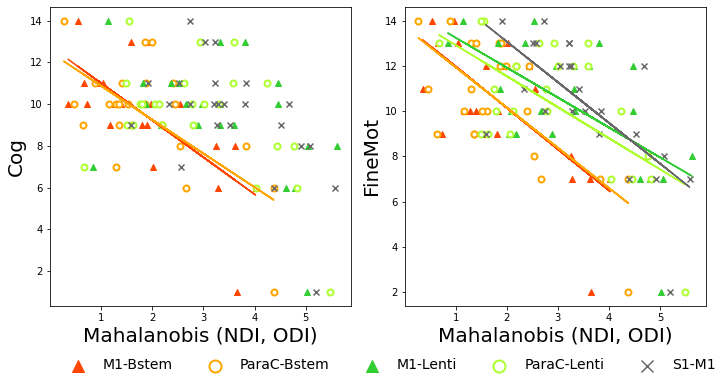

In [44]:
#fig, axs = plt.subplots(5,1,  figsize=(6,20),sharey=True, sharex=True)
fig, axs = plt.subplots(1,2,  figsize=(10,5),sharey=True, sharex=True)

for i, o in enumerate(out_rew):
    if o == 'Cognitive-ScaledScore':
        #ttl = 'Cog'
        imp = ['M1-Brainstem_mh_set3', 'Paracentral-Brainstem_mh_set3']
        bund = ['M1-Brainstem_mh_set3', 'Paracentral-Brainstem_mh_set3','M1-Lenti_mh_set3',
             'Paracentral-Lenti_mh_set3','S1-M1_mh_set3']
        #bund = ['M1-Brainstem_mh_set3', 'Paracentral-Brainstem_mh_set3']
        
    elif o == 'FineMotor-ScaledScore':
        #ttl = 'FineMot'
        bund = ['M1-Brainstem_mh_set3', 'Paracentral-Brainstem_mh_set3','M1-Lenti_mh_set3',
             'Paracentral-Lenti_mh_set3','S1-M1_mh_set3']
        imp = ['M1-Brainstem_mh_set3', 'Paracentral-Brainstem_mh_set3','M1-Lenti_mh_set3',
             'Paracentral-Lenti_mh_set3','S1-M1_mh_set3']
    else:
        imp = []
    for s in bund:


        scat = axs[i].scatter(extreme_mh_outcomes[s],extreme_mh_outcomes[o], c = c_scheme_rew[s][0], marker= c_scheme_rew[s][1], 
               label = c_scheme_rew[s][2] )
        
        ### regression 
        if s in imp:
            m, b = np.polyfit(np.float32(extreme_mh_outcomes[s].values), np.float32(extreme_mh_outcomes[o].values), 1)
            axs[i].plot(extreme_mh_outcomes[s], 
                                  m* extreme_mh_outcomes[s] + b, 
                                 c = c_scheme_rew[s][0])
        
        if s in ['Paracentral-Brainstem_mh_set3','Paracentral-Lenti_mh_set3' ]:
            scat.set_facecolors('w')
            scat.set_edgecolors(c_scheme_rew[s][0])
            scat.set_linewidths(2)
        axs[i].set_ylabel(ttl[i], fontsize=20)
        axs[i].set_xlabel('Mahalanobis (NDI, ODI)', fontsize=20)
        #axs[i].set_ylim([0,20])
plt.tight_layout()
#axs[1].legend(loc='center', bbox_to_anchor=(0.5, 2.3), 
#          ncol = 3, fontsize=12, frameon=False, markerscale=1.2)
axs[1].legend(loc='center', bbox_to_anchor=(-0.05, -0.2), 
          ncol = 5, fontsize=14, frameon=False, markerscale=2)
    
fig.patch.set_facecolor('white')
#plt.savefig('../../Results/figures/scatter_mah_outcomes_2_swapped_all_bundles.png', bbox_inches='tight',dpi=500)
plt.show()


In [25]:
outcomes = ['Cognitive', 'Language', 'Motor']

corr_with_outcome= pd.DataFrame()
r_with_outcome= pd.DataFrame()

i=0
for bundle in pair_names:
    
    corr_with_outcome.loc[i, 'bundle'] = bundle
    r_with_outcome.loc[i, 'bundle'] = bundle
    
    for subset in ['set1', 'set2', 'set3']:
        for score in outcomes:
    
            test = pg.corr(extreme_mh_outcomes[bundle + '_mh_'+ subset], extreme_mh_outcomes[score])
            
            corr_with_outcome.loc[i, score+'_'+subset] = np.round(test['p-val'][0],5)
            r_with_outcome.loc[i, score+'_'+subset] = np.round(test['r'][0],5)
    i = i +1 
    
corr_with_outcome[corr_with_outcome.columns[1:]] = corr_with_outcome[corr_with_outcome.columns[1:]].astype(np.float64)
pre_p = corr_with_outcome[corr_with_outcome.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(corr_with_outcome[corr_with_outcome.columns[1:]].values))
corr_with_outcome[corr_with_outcome.columns[1:]] = pvals_corr

In [26]:
corr_with_outcome.to_csv('../../Results/extreme_group_mahalanobis_correlation_with_outcome.csv')

In [27]:
r_with_outcome.to_csv('../../Results/extreme_group_mahalanobis_correlation_with_outcome_pearsonr.csv')

In [31]:
#scaled scores
outcomes = ['Cognitive-ScaledScore', 'ReceptiveCom-ScaledScore', 'ExpressiveCom-ScaledScore',
'FineMotor-ScaledScore','GrossMotor-ScaledScore']

corr_with_outcome= pd.DataFrame()
r_with_outcome= pd.DataFrame()

i=0
for bundle in pair_names:
    
    corr_with_outcome.loc[i, 'bundle'] = bundle
    r_with_outcome.loc[i, 'bundle'] = bundle
    
    for subset in ['set1', 'set2', 'set3']:
        for score in outcomes:
    
            test = pg.corr(extreme_mh_outcomes[bundle + '_mh_'+ subset], extreme_mh_outcomes[score])
            
            corr_with_outcome.loc[i, score+'_'+subset] = np.round(test['p-val'][0],5)
            r_with_outcome.loc[i, score+'_'+subset] = np.round(test['r'][0],5)
    i = i +1 
    
corr_with_outcome[corr_with_outcome.columns[1:]] = corr_with_outcome[corr_with_outcome.columns[1:]].astype(np.float64)
pre_p = corr_with_outcome[corr_with_outcome.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(corr_with_outcome[corr_with_outcome.columns[1:]].values))
corr_with_outcome[corr_with_outcome.columns[1:]] = pvals_corr

In [32]:
corr_with_outcome.to_csv('../../Results/extreme_group_mahalanobis_correlation_with_scaled_scores.csv')

In [33]:
r_with_outcome.to_csv('../../Results/extreme_group_mahalanobis_correlation_with_scaled_scores_pearsonr.csv')

In [24]:
outcomes = ['Cognitive', 'Language', 'Motor']

corr_with_outcome= pd.DataFrame()

i=0
for bundle in pair_names:
    
    corr_with_outcome.loc[i, 'bundle'] = bundle
    
    for subset in ['set1', 'set2', 'set3']:
        for score in outcomes:
    
            test = pg.corr(moderate_mh_outcomes[bundle + '_mh_'+ subset], moderate_mh_outcomes[score])
            
            corr_with_outcome.loc[i, score+'_'+subset] = np.round(test['p-val'][0],5)
    i = i +1 
    
corr_with_outcome[corr_with_outcome.columns[1:]] = corr_with_outcome[corr_with_outcome.columns[1:]].astype(np.float64)
pre_p = corr_with_outcome[corr_with_outcome.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(corr_with_outcome[corr_with_outcome.columns[1:]].values))
corr_with_outcome[corr_with_outcome.columns[1:]] = pvals_corr

In [25]:
corr_with_outcome.to_csv('../../Results/moderate_group_mahalanobis_correlation_with_outcome.csv')

In [26]:
#scaled scores
outcomes = ['Cognitive-ScaledScore', 'ReceptiveCom-ScaledScore', 'ExpressiveCom-ScaledScore',
'FineMotor-ScaledScore','GrossMotor-ScaledScore']

corr_with_outcome= pd.DataFrame()

i=0
for bundle in pair_names:
    
    corr_with_outcome.loc[i, 'bundle'] = bundle
    
    for subset in ['set1', 'set2', 'set3']:
        for score in outcomes:
    
            test = pg.corr(moderate_mh_outcomes[bundle + '_mh_'+ subset], moderate_mh_outcomes[score])
            
            corr_with_outcome.loc[i, score+'_'+subset] = np.round(test['p-val'][0],5)
    i = i +1 
    
corr_with_outcome[corr_with_outcome.columns[1:]] = corr_with_outcome[corr_with_outcome.columns[1:]].astype(np.float64)
pre_p = corr_with_outcome[corr_with_outcome.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(corr_with_outcome[corr_with_outcome.columns[1:]].values))
corr_with_outcome[corr_with_outcome.columns[1:]] = pvals_corr

In [27]:
corr_with_outcome.to_csv('../../Results/moderate_group_mahalanobis_correlation_with_scaled_scores.csv')

### Prepare Malahanobis for anova 

In [11]:
import pandas as pd 

In [23]:
extreme_mh_results_1 = extreme_mh_results.copy()
moderate_mh_results_1 = moderate_mh_results.copy()

extreme_mh_results_1['group'] = 1
moderate_mh_results_1['group'] = 2

new_mh_concat = pd.concat([extreme_mh_results_1, moderate_mh_results_1])

for subset in ['set1', 'set2', 'set3']:
    cols = [col for col in extreme_mh_results_1.columns if subset in col]
    df_subset = new_mh_concat[['subject_id', 'group'] + cols].copy()
    df_subset = pd.melt(df_subset, id_vars=['subject_id', 'group'], value_vars=[col for col in df_subset.columns if 'mh' in col])

    df_subset.rename(columns={'variable':'tract'}, inplace=True)
    df_subset.to_csv('../../Results/Mahalanobis_for_anova_{}.csv'.format(subset))
    

### Check if moderate is different from 0 

In [38]:
ttest_res = pd.DataFrame()
i = 0

for pair in pair_names:
    ttest_res.loc[i, 'tract'] = pair
    
    for subset in ['set1', 'set2', 'set3']:
    
        bundle = pair + '_mh_' + subset
        
        test = pg.ttest(moderate_mh_results[bundle],0)
        
        ttest_res.loc[i, subset] = test['p-val'].values[0]
    i = i+1   
    
ttest_res[['set1', 'set2', 'set3']] = ttest_res[['set1', 'set2', 'set3']].astype(np.float64)
pre_p = ttest_res[['set1', 'set2', 'set3']].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(ttest_res[['set1', 'set2', 'set3']].values))

ttest_res[['set1', 'set2', 'set3']] = pvals_corr

In [41]:
ttest_res.to_csv('moderate_mh_ttest_to_0.csv')

#### using One-Sample Wilcoxon Signed Rank Test

In [2]:
extreme_mh_results = pd.read_csv('../../Results/mahalanabis_bundle_metrics_extreme_pt.csv', index_col=0)
moderate_mh_results = pd.read_csv('../../Results/mahalanabis_bundle_metrics_moderate_pt.csv', index_col=0)

In [11]:
#### moderate 
ttest_res = pd.DataFrame()
i = 0

for pair in pair_names:
    ttest_res.loc[i, 'tract'] = pair
    
    for subset in ['set1', 'set2', 'set3']:
    
        bundle = pair + '_mh_' + subset
        
        #test = pg.wilcoxon(moderate_mh_results[bundle],0)
        test = pg.wilcoxon(moderate_mh_results[bundle], np.zeros_like(moderate_mh_results[bundle]))
        
        ttest_res.loc[i, subset] = test['p-val'].values[0]
    i = i+1   
    
ttest_res[['set1', 'set2', 'set3']] = ttest_res[['set1', 'set2', 'set3']].astype(np.float64)
pre_p = ttest_res[['set1', 'set2', 'set3']].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(ttest_res[['set1', 'set2', 'set3']].values))

ttest_res[['set1', 'set2', 'set3']] = pvals_corr

ttest_res.to_csv('moderate_mh_wilcoxon_to_0.csv')

#### extreme

ttest_res = pd.DataFrame()
i = 0

for pair in pair_names:
    ttest_res.loc[i, 'tract'] = pair
    
    for subset in ['set1', 'set2', 'set3']:
    
        bundle = pair + '_mh_' + subset
        
        #test = pg.wilcoxon(moderate_mh_results[bundle],0)
        test = pg.wilcoxon(extreme_mh_results[bundle], np.zeros_like(extreme_mh_results[bundle]))
        
        ttest_res.loc[i, subset] = test['p-val'].values[0]
    i = i+1   
    
ttest_res[['set1', 'set2', 'set3']] = ttest_res[['set1', 'set2', 'set3']].astype(np.float64)
pre_p = ttest_res[['set1', 'set2', 'set3']].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(ttest_res[['set1', 'set2', 'set3']].values))

ttest_res[['set1', 'set2', 'set3']] = pvals_corr

ttest_res.to_csv('extreme_mh_wilcoxon_to_0.csv')


## Test for the normality all the bundles 

In [21]:
#### moderate 
ttest_res = pd.DataFrame()
i = 0

for pair in pair_names:
    ttest_res.loc[i, 'tract'] = pair
    
    for subset in ['set1', 'set2', 'set3']:
    
        bundle = pair + '_mh_' + subset
        
        #test = pg.wilcoxon(moderate_mh_results[bundle],0)
        test = pg.normality(moderate_mh_results[bundle])
        
        ttest_res.loc[i, subset] = test['pval'].values[0]
    i = i+1   
    
ttest_res[['set1', 'set2', 'set3']] = ttest_res[['set1', 'set2', 'set3']].astype(np.float64)
pre_p = ttest_res[['set1', 'set2', 'set3']].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(ttest_res[['set1', 'set2', 'set3']].values))

ttest_res[['set1', 'set2', 'set3']] = pvals_corr

ttest_res.to_csv('moderate_mh_normality_test.csv')

#### extreme
ttest_res = pd.DataFrame()
i = 0

for pair in pair_names:
    ttest_res.loc[i, 'tract'] = pair
    
    for subset in ['set1', 'set2', 'set3']:
    
        bundle = pair + '_mh_' + subset
        
        #test = pg.wilcoxon(moderate_mh_results[bundle],0)
        test = pg.normality(extreme_mh_results[bundle])
        
        ttest_res.loc[i, subset] = test['pval'].values[0]
    i = i+1   
    
ttest_res[['set1', 'set2', 'set3']] = ttest_res[['set1', 'set2', 'set3']].astype(np.float64)
pre_p = ttest_res[['set1', 'set2', 'set3']].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(ttest_res[['set1', 'set2', 'set3']].values))

ttest_res[['set1', 'set2', 'set3']] = pvals_corr

ttest_res.to_csv('extreme_mh_normality_test.csv')

# Plotting the bundle comparison results 

In [2]:
ordering = pd.read_csv('../../Results/new_mahalanobis_extreme_group_ordering.csv', index_col=0)

In [5]:
ordering

,region1,region2,corrected_p_set1,corrected_p_set2,corrected_p_set3,region1_set1_mean,region2_set1_mean,region1_set2_mean,region2_set2_mean,region1_set3_mean,region2_set3_mean
0,M1-Brainstem,S1-Brainstem,0.00447,0.01767,0.00006,1.268042,1.656967,1.491494,1.780472,1.704757,2.161302
1,M1-Brainstem,Paracentral-Brainstem,0.32156,0.27154,0.94016,1.268042,1.435655,1.491494,1.612406,1.704757,1.439010
2,M1-Brainstem,M1-Caud,0.36985,0.28711,0.00475,1.268042,1.701806,1.491494,1.837961,1.704757,1.935281
3,M1-Brainstem,S1-Caud,0.00052,0.00034,0.00922,1.268042,1.783349,1.491494,1.891886,1.704757,1.470492
4,M1-Brainstem,Paracentral-Caud,0.20120,0.27488,0.02287,1.268042,1.937981,1.491494,1.902205,1.704757,1.673048
...,...,...,...,...,...,...,...,...,...,...,...
100,Paracentral-Thalfus,S1L-S1R,0.00046,0.00022,0.15190,1.798053,1.978371,1.829133,2.153421,1.658431,1.508465
101,Paracentral-Thalfus,S1-M1,0.00000,0.00000,0.00000,1.798053,2.710799,1.829133,2.667500,1.658431,2.210219
102,M1L-M1R,S1L-S1R,0.73207,0.38604,0.79866,2.300694,1.978371,2.303228,2.153421,1.941375,1.508465
103,M1L-M1R,S1-M1,0.00017,0.00247,0.00000,2.300694,2.710799,2.303228,2.667500,1.941375,2.210219


In [8]:
ordering[ordering.region2 == 'S1-M1']

,region1,region2,corrected_p_set1,corrected_p_set2,corrected_p_set3,region1_set1_mean,region2_set1_mean,region1_set2_mean,region2_set2_mean,region1_set3_mean,region2_set3_mean
13,M1-Brainstem,S1-M1,0.00000,0.00000,0.00000,1.268042,2.710799,1.491494,2.6675,1.704757,2.210219
26,S1-Brainstem,S1-M1,0.00000,0.00000,0.00000,1.656967,2.710799,1.780472,2.6675,2.161302,2.210219
38,Paracentral-Brainstem,S1-M1,0.00000,0.00000,0.00000,1.435655,2.710799,1.612406,2.6675,1.439010,2.210219
49,M1-Caud,S1-M1,0.00000,0.00000,0.00000,1.701806,2.710799,1.837961,2.6675,1.935281,2.210219
59,S1-Caud,S1-M1,0.00000,0.00003,0.00000,1.783349,2.710799,1.891886,2.6675,1.470492,2.210219
68,Paracentral-Caud,S1-M1,0.00000,0.00000,0.00000,1.937981,2.710799,1.902205,2.6675,1.673048,2.210219
76,M1-Lenti,S1-M1,0.00000,0.00000,0.00346,1.725644,2.710799,1.792370,2.6675,1.714232,2.210219
83,S1-Lenti,S1-M1,0.01457,0.02878,0.72267,1.983409,2.710799,2.001498,2.6675,1.981186,2.210219
89,Paracentral-Lenti,S1-M1,0.00000,0.00000,0.00006,1.765831,2.710799,1.823361,2.6675,1.579891,2.210219
94,M1-Thalfus,S1-M1,0.00000,0.00000,0.00000,1.382208,2.710799,1.417602,2.6675,1.333496,2.210219


#### set 1 - extreme

In [504]:
import random, math

regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
    
means = [reg for reg in ordering.region1_set1_mean.values]
for reg in ordering.region2_set1_mean.values:
    means.append(reg)


edges = []
weights = []

for i, row in ordering.iterrows():
    if row.corrected_p_set1 > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p_set1)

In [505]:
pos = {}
for i, reg in enumerate(regions):
    pos[reg] = np.array([0, means[i]])

a = np.array([key for key in pos.keys()])
b = np.array([pos[key][1] for key in pos.keys()])


b_sc = StandardScaler().fit_transform(b.reshape(-1,1))
b_sc = MinMaxScaler(feature_range=(0,1)).fit_transform(b_sc).reshape(1,-1)[0]


sorted_regions = a[b_sc.argsort()[::-1]]
b_sc_sorted= b_sc[b_sc.argsort()[::-1]]

def sigmoid(x, e = 0.01):
    return 1/ (1 + math.exp(-e*(x)))


mult = [1.25, 1.25, 1.25, 1.25, 1.2, 1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
for i, reg in enumerate(sorted_regions):
    
    pos[reg][1] =  sigmoid(b_sc_sorted[i]-0.2, e=2)   * mult[i]
    
    if  i<= 2 or i >=11:
        loc = 6   
    elif 2<i<6:
        loc = i* 1.05
    elif 6<= i < 11:
        loc = i*0.95

    pos[reg][0] =sigmoid(len(sorted_regions) -loc) 
    

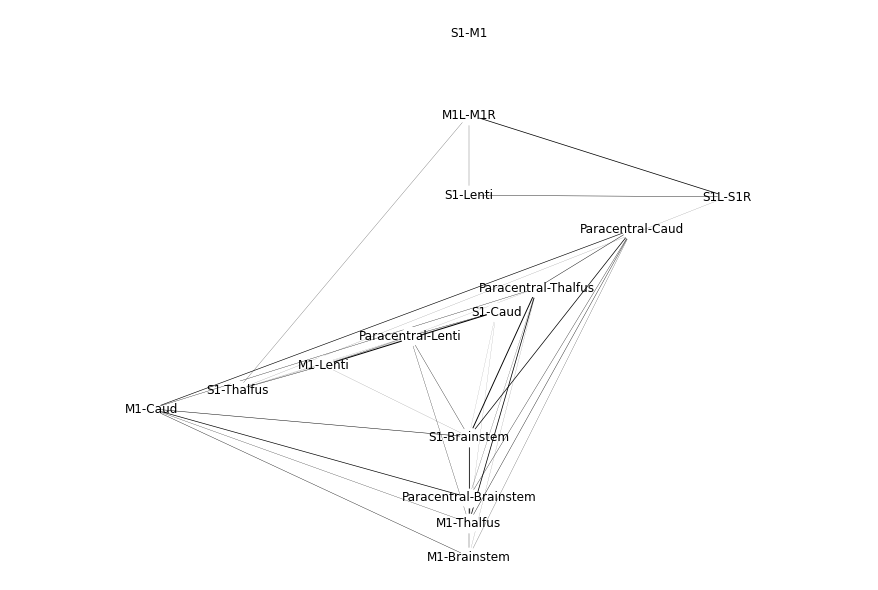

In [506]:
import networkx as nx 
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)


options = {
    'font_size': 12,
    #'node_size' : 5000,
    'node_color': 'white',
    #'edgecolors' : 'black',
    'linewidths': 2.5,
    'width': list(weights)
}

plt.figure(figsize=(12,8))


nx.draw(G, pos, with_labels= True, **options)

#edge_labels = nx.get_edge_attributes(G,'weights')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

In [395]:
regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
regions = np.unique(regions)   
means = []
for reg in regions:
    
    for i, row in ordering.iterrows():
        
        if row.region1 == reg :
            val =  row.region1_set1_mean
            
        elif row.region2 == reg :
        
            val =  row.region2_set1_mean
    means.append(val)       
        


r_sorted = np.array(regions)[np.array(means).argsort()[::-1]]



for reg in r_sorted:
    ord_sub = ordering[(ordering.region1 == reg) | (ordering.region2 == reg)] 
    
    subset = []
    
    for i, row in ord_sub.iterrows():
        if row.region1 == reg and row.corrected_p_set1 > 0.05:
        
            subset.append(row.region2)
            
        elif row.region2 == reg and row.corrected_p_set1 > 0.05:
    
            subset.append(row.region1)
    
    print(reg, subset)

S1-M1 []
M1L-M1R ['S1-Lenti', 'S1-Thalfus', 'S1L-S1R']
S1-Lenti ['M1L-M1R', 'S1L-S1R']
S1L-S1R ['S1-Lenti', 'S1-Thalfus', 'M1L-M1R']
Paracentral-Caud ['M1-Brainstem', 'S1-Brainstem', 'Paracentral-Brainstem', 'M1-Caud', 'M1-Thalfus', 'Paracentral-Thalfus']
Paracentral-Thalfus ['M1-Brainstem', 'S1-Brainstem', 'Paracentral-Brainstem', 'M1-Caud', 'Paracentral-Caud', 'Paracentral-Lenti', 'M1-Thalfus']
S1-Caud ['S1-Brainstem', 'M1-Lenti', 'Paracentral-Lenti', 'M1-Thalfus', 'S1-Thalfus']
Paracentral-Lenti ['S1-Brainstem', 'S1-Caud', 'M1-Lenti', 'M1-Thalfus', 'S1-Thalfus', 'Paracentral-Thalfus']
M1-Lenti ['S1-Brainstem', 'S1-Caud', 'Paracentral-Lenti', 'S1-Thalfus']
S1-Thalfus ['S1-Caud', 'M1-Lenti', 'Paracentral-Lenti', 'M1L-M1R', 'S1L-S1R']
M1-Caud ['M1-Brainstem', 'S1-Brainstem', 'Paracentral-Brainstem', 'Paracentral-Caud', 'M1-Thalfus', 'Paracentral-Thalfus']
S1-Brainstem ['Paracentral-Brainstem', 'M1-Caud', 'S1-Caud', 'Paracentral-Caud', 'M1-Lenti', 'Paracentral-Lenti', 'M1-Thalfus', 'Par

#### Set 2 - extreme

In [484]:

regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
    
means = [reg for reg in ordering.region1_set2_mean.values]
for reg in ordering.region2_set2_mean.values:
    means.append(reg)


edges = []
weights = []

for i, row in ordering.iterrows():
    if row.corrected_p_set2 > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p_set2)
        
        
pos = {}
for i, reg in enumerate(regions):
    pos[reg] = np.array([0, means[i]])

a = np.array([key for key in pos.keys()])
b = np.array([pos[key][1] for key in pos.keys()])


b_sc = StandardScaler().fit_transform(b.reshape(-1,1))
b_sc = MinMaxScaler(feature_range=(0,1)).fit_transform(b_sc).reshape(1,-1)[0]


sorted_regions = a[b_sc.argsort()[::-1]]
b_sc_sorted= b_sc[b_sc.argsort()[::-1]]

def sigmoid(x, e = 0.01):
    return 1/ (1 + math.exp(-e*(x)))


mult = [1.25, 1.3, 1.25, 1.25, 1.2, 1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
for i, reg in enumerate(sorted_regions):
    
    pos[reg][1] =  sigmoid(b_sc_sorted[i]-0.2, e=2)   * mult[i]
    
    if  i<= 2 or i >=11:
        loc = 6   
    elif 2<i<6:
        loc = i* 0.95
    elif 6<= i < 11:
        loc = i*1.05

    pos[reg][0] =sigmoid(len(sorted_regions) -loc) 
    
    
    

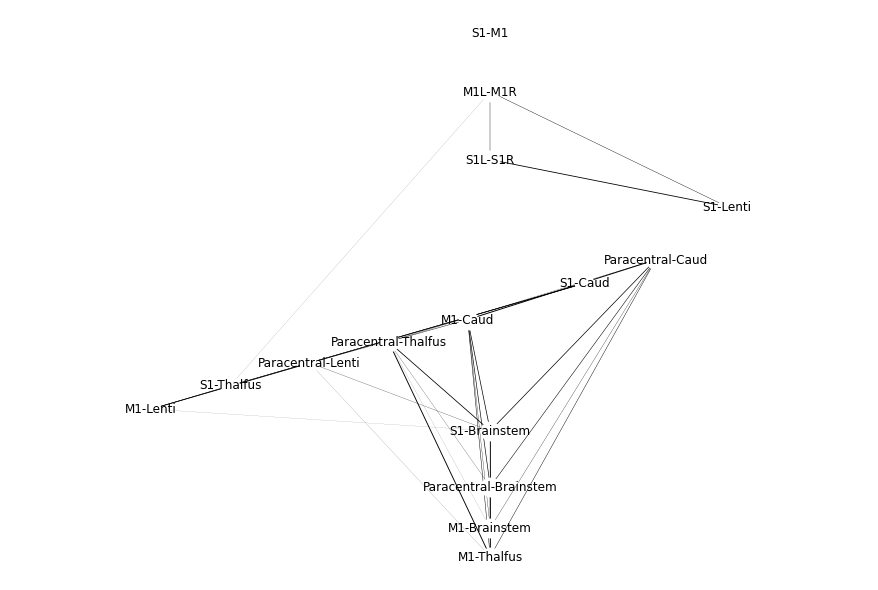

In [485]:
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)


options = {
    'font_size': 12,
    #'node_size' : 5000,
    'node_color': 'white',
    #'edgecolors' : 'black',
    'linewidths': 2.5,
    'width': list(weights)
}

plt.figure(figsize=(12,8))


nx.draw(G, pos, with_labels= True, **options)

#edge_labels = nx.get_edge_attributes(G,'weights')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

#### set 3 

In [488]:

regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
    
means = [reg for reg in ordering.region1_set3_mean.values]
for reg in ordering.region2_set3_mean.values:
    means.append(reg)


edges = []
weights = []

for i, row in ordering.iterrows():
    if row.corrected_p_set3 > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p_set3)
        
        
pos = {}
for i, reg in enumerate(regions):
    pos[reg] = np.array([0, means[i]])

a = np.array([key for key in pos.keys()])
b = np.array([pos[key][1] for key in pos.keys()])


b_sc = StandardScaler().fit_transform(b.reshape(-1,1))
b_sc = MinMaxScaler(feature_range=(0,1)).fit_transform(b_sc).reshape(1,-1)[0]


sorted_regions = a[b_sc.argsort()[::-1]]
b_sc_sorted= b_sc[b_sc.argsort()[::-1]]

def sigmoid(x, e = 0.01):
    return 1/ (1 + math.exp(-e*(x)))


mult = [1.25, 1.325, 1.25, 1.25, 1.2, 1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
for i, reg in enumerate(sorted_regions):
    
    pos[reg][1] =  sigmoid(b_sc_sorted[i]-0.2, e=2)   * mult[i]
    
    if  i<= 2 or i >=11:
        loc = 6   
    elif 2<i<6:
        loc = i* 0.95
    elif 6<= i < 11:
        loc = i*1.05

    pos[reg][0] =sigmoid(len(sorted_regions) -loc) 

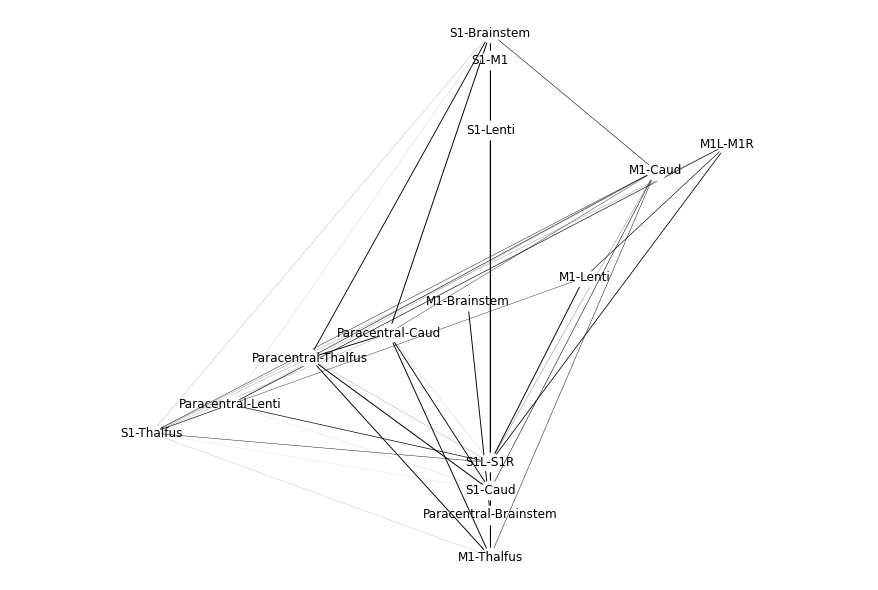

In [489]:
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)


options = {
    'font_size': 12,
    #'node_size' : 5000,
    'node_color': 'white',
    #'edgecolors' : 'black',
    'linewidths': 2.5,
    'width': list(weights)
}

plt.figure(figsize=(12,8))


nx.draw(G, pos, with_labels= True, **options)

#edge_labels = nx.get_edge_attributes(G,'weights')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

#### set 1 moderate 


In [496]:
ordering = pd.read_csv('../../Results/new_mahalanobis_moderate_group_ordering.csv', index_col=0)

In [497]:
regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
    
means = [reg for reg in ordering.region1_set1_mean.values]
for reg in ordering.region2_set1_mean.values:
    means.append(reg)


edges = []
weights = []

for i, row in ordering.iterrows():
    if row.corrected_p_set1 > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p_set1)
        
        
pos = {}
for i, reg in enumerate(regions):
    pos[reg] = np.array([0, means[i]])

a = np.array([key for key in pos.keys()])
b = np.array([pos[key][1] for key in pos.keys()])


b_sc = StandardScaler().fit_transform(b.reshape(-1,1))
b_sc = MinMaxScaler(feature_range=(0,1)).fit_transform(b_sc).reshape(1,-1)[0]


sorted_regions = a[b_sc.argsort()[::-1]]
b_sc_sorted= b_sc[b_sc.argsort()[::-1]]

def sigmoid(x, e = 0.01):
    return 1/ (1 + math.exp(-e*(x)))


mult = [1.25, 1.325, 1.25, 1.25, 1.2, 1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
for i, reg in enumerate(sorted_regions):
    
    pos[reg][1] =  sigmoid(b_sc_sorted[i]-0.2, e=2)   * mult[i]
    
    if  i<= 2 or i >=11:
        loc = 6   
    elif 2<i<6:
        loc = i* 0.95
    elif 6<= i < 11:
        loc = i*1.05

    pos[reg][0] =sigmoid(len(sorted_regions) -loc) 

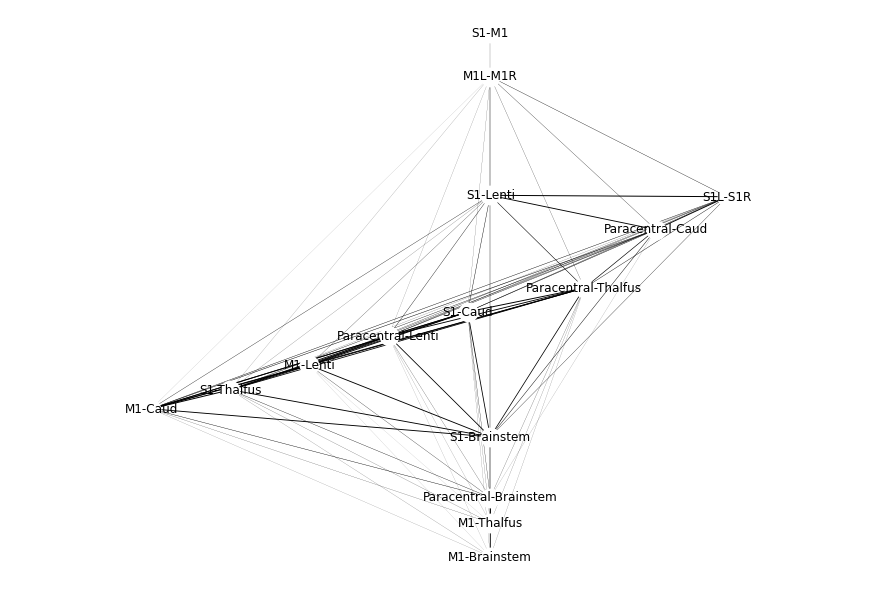

In [498]:
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)


options = {
    'font_size': 12,
    #'node_size' : 5000,
    'node_color': 'white',
    #'edgecolors' : 'black',
    'linewidths': 2.5,
    'width': list(weights)
}

plt.figure(figsize=(12,8))


nx.draw(G, pos, with_labels= True, **options)

#edge_labels = nx.get_edge_attributes(G,'weights')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

#### set 2 moderate 

In [499]:

regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
    
means = [reg for reg in ordering.region1_set2_mean.values]
for reg in ordering.region2_set2_mean.values:
    means.append(reg)


edges = []
weights = []

for i, row in ordering.iterrows():
    if row.corrected_p_set2 > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p_set2)
        
        
pos = {}
for i, reg in enumerate(regions):
    pos[reg] = np.array([0, means[i]])

a = np.array([key for key in pos.keys()])
b = np.array([pos[key][1] for key in pos.keys()])


b_sc = StandardScaler().fit_transform(b.reshape(-1,1))
b_sc = MinMaxScaler(feature_range=(0,1)).fit_transform(b_sc).reshape(1,-1)[0]


sorted_regions = a[b_sc.argsort()[::-1]]
b_sc_sorted= b_sc[b_sc.argsort()[::-1]]

def sigmoid(x, e = 0.01):
    return 1/ (1 + math.exp(-e*(x)))


mult = [1.25, 1.3, 1.25, 1.25, 1.2, 1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
for i, reg in enumerate(sorted_regions):
    
    pos[reg][1] =  sigmoid(b_sc_sorted[i]-0.2, e=2)   * mult[i]
    
    if  i<= 2 or i >=11:
        loc = 6   
    elif 2<i<6:
        loc = i* 0.95
    elif 6<= i < 11:
        loc = i*1.05

    pos[reg][0] =sigmoid(len(sorted_regions) -loc) 
    
    
    

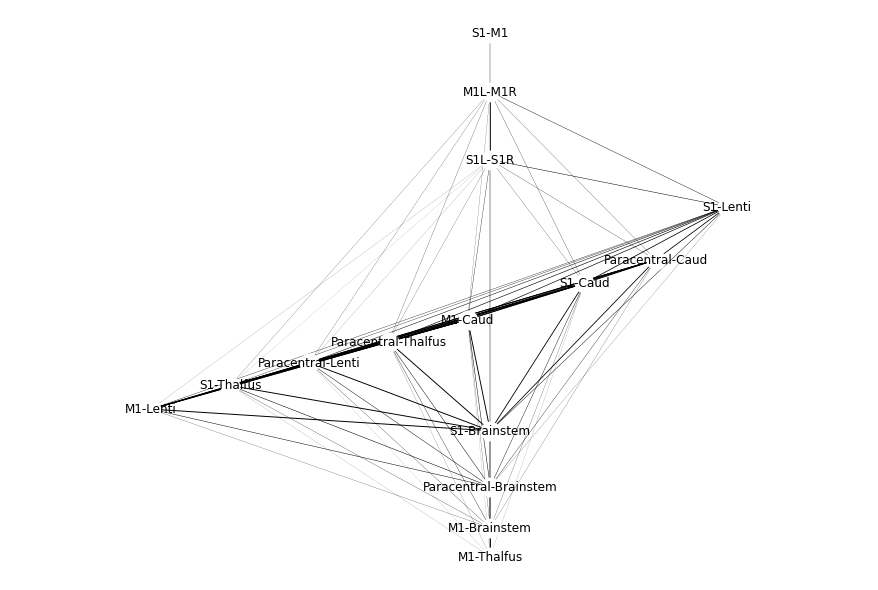

In [500]:
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)


options = {
    'font_size': 12,
    #'node_size' : 5000,
    'node_color': 'white',
    #'edgecolors' : 'black',
    'linewidths': 2.5,
    'width': list(weights)
}

plt.figure(figsize=(12,8))


nx.draw(G, pos, with_labels= True, **options)

#edge_labels = nx.get_edge_attributes(G,'weights')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

#### set 3 moderate 

In [501]:

regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
    
means = [reg for reg in ordering.region1_set3_mean.values]
for reg in ordering.region2_set3_mean.values:
    means.append(reg)


edges = []
weights = []

for i, row in ordering.iterrows():
    if row.corrected_p_set3 > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p_set3)
        
        
pos = {}
for i, reg in enumerate(regions):
    pos[reg] = np.array([0, means[i]])

a = np.array([key for key in pos.keys()])
b = np.array([pos[key][1] for key in pos.keys()])


b_sc = StandardScaler().fit_transform(b.reshape(-1,1))
b_sc = MinMaxScaler(feature_range=(0,1)).fit_transform(b_sc).reshape(1,-1)[0]


sorted_regions = a[b_sc.argsort()[::-1]]
b_sc_sorted= b_sc[b_sc.argsort()[::-1]]

def sigmoid(x, e = 0.01):
    return 1/ (1 + math.exp(-e*(x)))


mult = [1.25, 1.325, 1.25, 1.25, 1.2, 1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
for i, reg in enumerate(sorted_regions):
    
    pos[reg][1] =  sigmoid(b_sc_sorted[i]-0.2, e=2)   * mult[i]
    
    if  i<= 2 or i >=11:
        loc = 6   
    elif 2<i<6:
        loc = i* 0.95
    elif 6<= i < 11:
        loc = i*1.05

    pos[reg][0] =sigmoid(len(sorted_regions) -loc) 

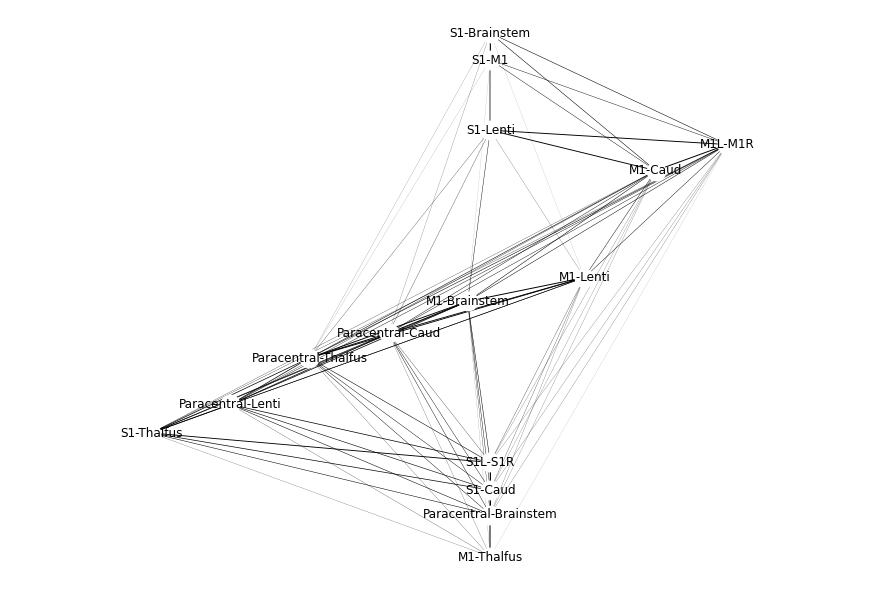

In [502]:
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)


options = {
    'font_size': 12,
    #'node_size' : 5000,
    'node_color': 'white',
    #'edgecolors' : 'black',
    'linewidths': 2.5,
    'width': list(weights)
}

plt.figure(figsize=(12,8))


nx.draw(G, pos, with_labels= True, **options)

#edge_labels = nx.get_edge_attributes(G,'weights')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

## comapare moderate vs extreme 
### unpaired t-tests


In [4]:
tract_ordering = [
    'S1-Brainstem_mh_',
    'M1-Brainstem_mh_',
    'Paracentral-Brainstem_mh_',
    
    'S1-Thalfus_mh_',
    'M1-Thalfus_mh_',
    'Paracentral-Thalfus_mh_',
    
    'S1-Caud_mh_',
    'M1-Caud_mh_',
    'Paracentral-Caud_mh_',
    
    'S1-Lenti_mh_',
    'M1-Lenti_mh_',
    'Paracentral-Lenti_mh_',
    
    'S1L-S1R_mh_',
    'M1L-M1R_mh_',
    'S1-M1_mh_',
    ]

#M1 == preC, S1 == postC, Paracentral == paraC
tract_ord_names = [
     'S1-Bstem','M1-Bstem','ParaC-Bstem',
    'S1-Thal','M1-Thal','ParaC-Thal',
     'S1-Caud','M1-Caud','ParaC-Caud',
     'S1-Lenti','M1-Lenti','ParaC-Lenti', 
    'S1$_L$-S1$_R$','M1$_L$-M1$_R$',
    'S1-M1' ]


In [3]:
extreme_mh_results = pd.read_csv('../../Results/mahalanabis_bundle_metrics_extreme_pt.csv', index_col=0)
moderate_mh_results = pd.read_csv('../../Results/mahalanabis_bundle_metrics_moderate_pt.csv', index_col=0)

In [34]:
res_comp = pd.DataFrame()
res_comp_t = pd.DataFrame()

i=0

for tract in tract_ordering:
    
    res_comp.loc[i, 'tract'] = tract.split('_')[0]
    res_comp_t.loc[i, 'tract'] = tract.split('_')[0]
    
    for subset in ['set1', 'set2', 'set3']:
        
        bundle = tract+subset
        test = pg.ttest(extreme_mh_results[bundle],moderate_mh_results[bundle], correction='auto')
        
        
        res_comp.loc[i, subset] = test['p-val'].values[0]
        res_comp_t.loc[i, subset+'_T'] = test['T'].values[0]
    i = i+1  
    
res_comp[['set1', 'set2', 'set3']] = res_comp[['set1', 'set2', 'set3']].astype(np.float64)
pre_p = res_comp[['set1', 'set2', 'set3']].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(res_comp[['set1', 'set2', 'set3']].values))

res_comp[['set1', 'set2', 'set3']] = pvals_corr    
 
res = pd.merge(res_comp, res_comp_t, on='tract')
res = res.sort_index(axis=1, ascending=True)
res.to_csv('../../Results/Mahalanobis_bundle_specific_extreme_vs_moderate_ttest.csv')